# Prediction of White player winning probability

Prediction of White player winning probability using 10 classification model and comparing the performance of all these models and select the best one according the F1 score and AUC score 

In [76]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':100})
import seaborn as sns 


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [77]:
#Load dataset
df = pd.read_csv('train_data.csv')

In [78]:
#print head in order to have a quick view
df.head()

,MatchID,WhiteElo,BlackElo,ECO,eval,Result
0,1,2569,2462,D12,0.29,1
1,2,2581,2574,B00,-0.22,0
2,3,2573,2479,B53,-3.13,0
3,4,2602,2343,A40,1.00,1
4,5,2578,2575,C03,0.91,1


In [79]:
#print the shape of data
df.shape

(10000, 6)

In [80]:
#Print the columns of dataset
df.columns

Index(['MatchID', 'WhiteElo', 'BlackElo', 'ECO', 'eval', 'Result'], dtype='object')

In [81]:
#lets see the datatypes of features
df.dtypes

MatchID       int64
WhiteElo      int64
BlackElo      int64
ECO          object
eval        float64
Result        int64
dtype: object

As we can see there is many object types of data 

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MatchID   10000 non-null  int64  
 1   WhiteElo  10000 non-null  int64  
 2   BlackElo  10000 non-null  int64  
 3   ECO       10000 non-null  object 
 4   eval      10000 non-null  float64
 5   Result    10000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [83]:
# fill nan with mean value
df.fillna(df.mean(), inplace=True)
# fill na for categorical data
df.fillna(df.mode().iloc[0], inplace=True)

#check the missing values
df.isnull().sum()

MatchID     0
WhiteElo    0
BlackElo    0
ECO         0
eval        0
Result      0
dtype: int64

So, there is no missing values 

In [84]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MatchID,10000,NaN,NaN,NaN,5000.5,2886.9,1,2500.75,5000.5,7500.25,10000
WhiteElo,10000,NaN,NaN,NaN,2553.17,109.183,2300,2496,2539,2608,3157
BlackElo,10000,NaN,NaN,NaN,2552.93,108.099,2300,2497,2538,2607,3155
ECO,10000,442,A45,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eval,10000,NaN,NaN,NaN,0.424913,0.844965,-5.86,0.03,0.41,0.79,5.89
Result,10000,NaN,NaN,NaN,0.526,0.499349,0,0,1,1,1


# I will clean all the columns one by one

### first I will drop useless columns 

I think these two columns does not make sense because if the player started and 13 tuens(I see in turn column for this perticular id) then they should take some time to play but the start and last move time difference is zero, hence for this is not useful for our prediction I will drop it 

I think black_id, white_id and increment_code is also not usefull so, I will drop it too

In [85]:
# df = df.drop(['increment_code', 'white_id', 'black_id', 'difference'], axis =1)

## Moves

I am going to predict the probability of winning on the basis of first move of the both black and white player. 

In [86]:
# moves = df.moves.str.split(n=2, expand=True)
# moves

Splited the moves into three column, first column contains the first move of white player and second column contains the first move of black player and third column contains the rest of the moves which I am not going to consider into my model because it will take more time to do data manipulation I will do it later 

In [87]:
# df['white_1move'] = moves[0]
# df['black_1move']= moves[1]

In [88]:
df_wm = pd.crosstab(df.ECO, columns = df.Result, normalize = 'index')
df_wm.head()

Result,0,1
ECO,,
A00,0.437500,0.562500
A01,0.385417,0.614583
A02,0.390244,0.609756
A03,0.300000,0.700000
A04,0.417989,0.582011


In [89]:
df_wm.columns

Int64Index([0, 1], dtype='int64', name='Result')

In [90]:
df_wm['0']
# df['ECO'] = df['ECO'].map(dict(df_wm['Rsult']))

KeyError: '0'

probability of winning of white player by using their first move

In [ ]:
# df_bm = pd.crosstab(df.black_1move, columns = df.winner, normalize = 'index')
# df_bm.head()

winner,black,draw,white
black_1move,,,
Na6,0.000000,0.000000,1.000000
Nc6,0.382653,0.053571,0.563776
Nf6,0.486119,0.062611,0.451270
Nh6,0.166667,0.000000,0.833333
a5,0.260870,0.130435,0.608696


In [ ]:
dict(df_bm['white'])
df['black_1move'] = df['black_1move'].map(dict(df_bm['white']))

probability of winning of white player on the basis of first move of black player

In [91]:
# if result is 1 then winner is white
df['winner']= df['Result'].apply(lambda x: 'white' if x == 1 else 'black')
df['opening_eco'] = df['ECO']
df_ = pd.crosstab(df.ECO, columns = df.winner, normalize = 'index')
print(df_)
print(df)

winner     black     white
ECO                       
A00     0.437500  0.562500
A01     0.385417  0.614583
A02     0.390244  0.609756
A03     0.300000  0.700000
A04     0.417989  0.582011
..           ...       ...
E94     0.588235  0.411765
E95     0.666667  0.333333
E97     0.416667  0.583333
E98     0.428571  0.571429
E99     1.000000  0.000000

[442 rows x 2 columns]
      MatchID  WhiteElo  BlackElo  ECO  eval  Result winner opening_eco
0           1      2569      2462  D12  0.29       1  white         D12
1           2      2581      2574  B00 -0.22       0  black         B00
2           3      2573      2479  B53 -3.13       0  black         B53
3           4      2602      2343  A40  1.00       1  white         A40
4           5      2578      2575  C03  0.91       1  white         C03
...       ...       ...       ...  ...   ...     ...    ...         ...
9995     9996      2487      2510  B28  1.34       0  black         B28
9996     9997      2566      2697  A40  1.36     

In [92]:
dict(df_['white'])

{'A00': 0.5625,
 'A01': 0.6145833333333334,
 'A02': 0.6097560975609756,
 'A03': 0.7,
 'A04': 0.582010582010582,
 'A05': 0.5714285714285714,
 'A06': 0.5,
 'A07': 0.48314606741573035,
 'A08': 0.7222222222222222,
 'A09': 0.4888888888888889,
 'A10': 0.45454545454545453,
 'A11': 0.6666666666666666,
 'A12': 0.5,
 'A13': 0.47297297297297297,
 'A14': 0.5,
 'A15': 0.638095238095238,
 'A16': 0.4074074074074074,
 'A17': 0.625,
 'A18': 0.3333333333333333,
 'A19': 0.2,
 'A20': 0.6511627906976745,
 'A21': 0.6086956521739131,
 'A22': 0.42857142857142855,
 'A23': 0.5,
 'A24': 0.0,
 'A25': 0.5,
 'A27': 0.625,
 'A28': 0.3157894736842105,
 'A29': 0.6666666666666666,
 'A30': 0.5652173913043478,
 'A31': 0.6111111111111112,
 'A32': 0.5,
 'A33': 0.7142857142857143,
 'A34': 0.6666666666666666,
 'A35': 0.5454545454545454,
 'A36': 0.2857142857142857,
 'A37': 0.5384615384615384,
 'A38': 0.0,
 'A39': 0.5,
 'A40': 0.5533980582524272,
 'A41': 0.5185185185185185,
 'A42': 0.47058823529411764,
 'A43': 0.57471264367816

In [93]:
df['opening_eco']= df['opening_eco'].map(dict(df_['white']))

In [94]:
df.head()

,MatchID,WhiteElo,BlackElo,ECO,eval,Result,winner,opening_eco
0,1,2569,2462,D12,0.29,1,white,0.588235
1,2,2581,2574,B00,-0.22,0,black,0.488636
2,3,2573,2479,B53,-3.13,0,black,0.555556
3,4,2602,2343,A40,1.00,1,white,0.553398
4,5,2578,2575,C03,0.91,1,white,0.333333


In [ ]:
df.opening_eco.nunique() # it 

442

In [ ]:
df.black_1move.nunique()

20

In [ ]:
df.isnull().sum()

MatchID        0
WhiteElo       0
BlackElo       0
ECO            0
eval           0
Result         0
winner         0
opening_eco    0
dtype: int64

There is 18 missing value acceptable because it is possible that they started the game white payer is the first who start the game maybe after start of the game black player gaveup to play

In [ ]:
df.dropna().head()

,id,rated,turns,victory_status,winner,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,white_1move,black_1move
0,TZJHLljE,False,13,outoftime,white,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,0.400000,Slav Defense: Exchange Variation,5,0.499337,0.493591
1,l1NXvwaE,True,16,resign,black,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,0.597381,Nimzowitsch Defense: Kennedy Variation,4,0.499337,0.563776
2,mIICvQHh,True,61,mate,white,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,0.442963,King's Pawn Game: Leonardis Variation,3,0.505715,0.515312
3,kWKvrqYL,True,61,mate,white,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,0.511521,Queen's Pawn Game: Zukertort Variation,3,0.499337,0.493591
4,9tXo1AUZ,True,95,mate,white,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,0.573082,Philidor Defense,5,0.505715,0.515312


In [ ]:
#df.moves.unique()

In [ ]:
df.opening_ply.nunique()

23

In [ ]:
df.opening_name.nunique()

1477

# Now I will treat the categorical varibles

### first lets check what is rated columns 

In [ ]:
df['rated'].unique()

array([False,  True])

so, it include two category true and false which seems if rated is true and if not rated is false which make sense, lets convert it into o and 1 form

In [ ]:
df.victory_status.unique()

array(['outoftime', 'resign', 'mate', 'draw'], dtype=object)

In [95]:
df.drop(columns = ['MatchID', 'ECO'], inplace = True)

In [96]:
df.head()

,WhiteElo,BlackElo,eval,Result,winner,opening_eco
0,2569,2462,0.29,1,white,0.588235
1,2581,2574,-0.22,0,black,0.488636
2,2573,2479,-3.13,0,black,0.555556
3,2602,2343,1.00,1,white,0.553398
4,2578,2575,0.91,1,white,0.333333


In [ ]:
df.replace({False: 0, True: 1}, inplace=True)

In [ ]:
df.head()

,MatchID,WhiteElo,BlackElo,ECO,eval,Result,winner,opening_eco
0,1,2569,2462,D12,0.29,1,white,D12
1,2,2581,2574,B00,-0.22,0,black,B00
2,3,2573,2479,B53,-3.13,0,black,B53
3,4,2602,2343,A40,1.00,1,white,A40
4,5,2578,2575,C03,0.91,1,white,C03


In [ ]:
df.replace({'white' : 1, 'black': 0, 'draw': 0}, inplace = True)

In [ ]:
df.head()

,WhiteElo,BlackElo,eval,Result,winner,opening_eco
0,2569,2462,0.29,1,1,D12
1,2581,2574,-0.22,0,0,B00
2,2573,2479,-3.13,0,0,B53
3,2602,2343,1.00,1,1,A40
4,2578,2575,0.91,1,1,C03


<AxesSubplot:>

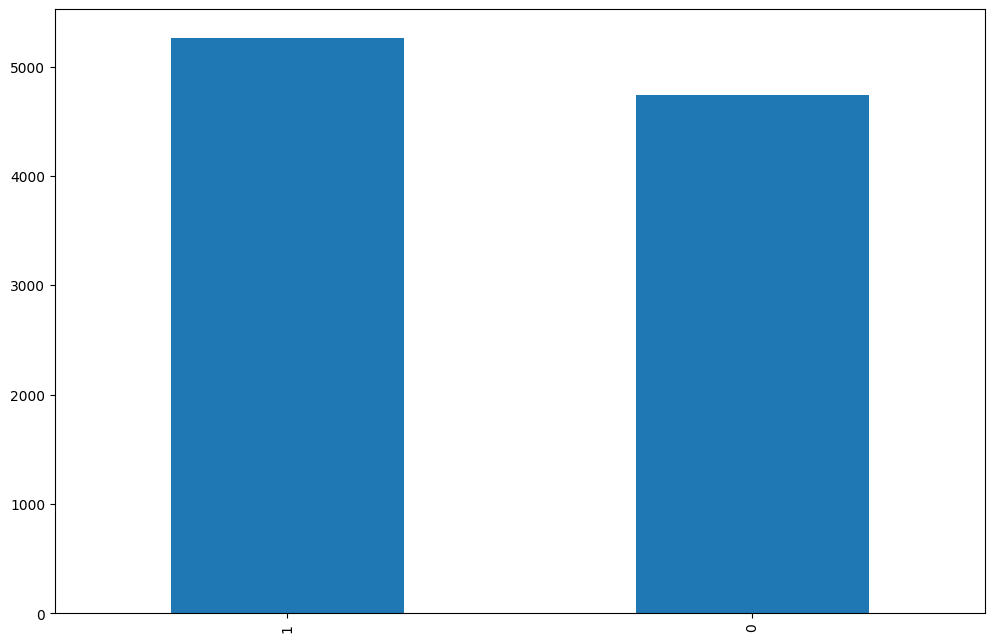

In [ ]:
df.winner.value_counts().plot(kind = 'bar')

In [ ]:
df.groupby('winner').rated.value_counts().plot(kind = 'bar')

AttributeError: 'DataFrameGroupBy' object has no attribute 'rated'

In [ ]:
df = df.dropna().copy() # it is not necessary to drop nan values

In [ ]:
df.to_csv('cleaned_data')

In [144]:
#features
df['Prob_win'] = np.ones(df.shape[0])/(np.ones(df.shape[0])+np.power(10, (df['BlackElo']-df['WhiteElo'])/400))
x = df.drop(['winner','Result'], axis = 1)
x

,WhiteElo,BlackElo,eval,opening_eco,Prob_win
0,2569,2462,0.29,0.588235,0.649295
1,2581,2574,-0.22,0.488636,0.510072
2,2573,2479,-3.13,0.555556,0.632070
3,2602,2343,1.00,0.553398,0.816217
4,2578,2575,0.91,0.333333,0.504317
...,...,...,...,...,...
9995,2487,2510,1.34,0.440000,0.466949
9996,2566,2697,1.36,0.553398,0.319929
9997,2498,2566,0.32,0.582011,0.403371
9998,2815,2486,0.50,0.551724,0.869197


In [145]:
#target
y = df.Result

In [101]:
y

0       1
1       0
2       0
3       1
4       1
       ..
9995    0
9996    0
9997    0
9998    1
9999    1
Name: Result, Length: 10000, dtype: int64

# Train Test split

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, stratify = y)

# Feature Scaling

In [148]:
from sklearn.preprocessing import StandardScaler

In [149]:
scaler=StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [150]:
x_train_scaled=scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [151]:
#pip install xgboost

In [152]:
#pip install catboost

# Models

### Model 1 Logistic Regression

In [153]:
model1 = LogisticRegression(class_weight = 'balanced',max_iter = 1e5)
model1.fit(x_train_scaled,y_train)

LogisticRegression(class_weight='balanced', max_iter=100000.0)

In [154]:
y_pred1 = model1.predict(x_test_scaled)

In [155]:
print(accuracy_score(y_test, y_pred1))
print(precision_score(y_test, y_pred1))
print(recall_score(y_test, y_pred1))
prob_1 = model1.predict_proba(x_test_scaled)

0.6483333333333333
0.6679511881824021
0.6590621039290241


In [156]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      1422
           1       0.67      0.66      0.66      1578

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.65      3000
weighted avg       0.65      0.65      0.65      3000



# Feature Importance

In [157]:
#pd.Series(model1.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Model 2 KNN

In [158]:
model2= KNeighborsClassifier(2)
model2.fit(x_train_scaled, y_train)
y_pred2= model2.predict(x_test_scaled)

In [159]:
print(accuracy_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))
prob_2 = model1.predict_proba(x_test_scaled)

0.549
0.6203208556149733
0.36755386565272496


In [160]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.52      0.75      0.61      1422
           1       0.62      0.37      0.46      1578

    accuracy                           0.55      3000
   macro avg       0.57      0.56      0.54      3000
weighted avg       0.57      0.55      0.53      3000



# Feature importance

In [161]:
#importances = CV_RFR_regr.best_estimator_.feature_importances_

### Model 3 Gaussian

In [162]:
model3= GaussianNB()
model3.fit(x_train_scaled, y_train)
y_pred3= model3.predict(x_test_scaled)

In [163]:
print(confusion_matrix(y_test, y_pred3))
print(accuracy_score(y_test, y_pred3))
print(precision_score(y_test, y_pred3))
print(recall_score(y_test, y_pred3))
prob_3 = model3.predict_proba(x_test_scaled)

[[ 852  570]
 [ 508 1070]]
0.6406666666666667
0.6524390243902439
0.6780735107731305


In [164]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1422
           1       0.65      0.68      0.67      1578

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



# Feature importance

### Model 4 support vector machine

In [165]:
model4= SVC(probability =True)
model4.fit(x_train_scaled, y_train)
y_pred4= model4.predict(x_test_scaled)

In [166]:
print(accuracy_score(y_test, y_pred4))
print(precision_score(y_test, y_pred4))
print(recall_score(y_test, y_pred4))
prob_4 = model4.predict_proba(x_test_scaled)

0.6503333333333333
0.656047197640118
0.7046894803548795


In [167]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.64      0.59      0.62      1422
           1       0.66      0.70      0.68      1578

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.65      3000
weighted avg       0.65      0.65      0.65      3000



### Model 5 Decision Tree

In [168]:
model5= DecisionTreeClassifier()
model5.fit(x_train_scaled, y_train)
y_pred5= model5.predict(x_test_scaled)

In [169]:
print(accuracy_score(y_test, y_pred5))
print(precision_score(y_test, y_pred5))
print(recall_score(y_test, y_pred5))
prob_5 = model5.predict_proba(x_test_scaled)

0.5573333333333333
0.5791139240506329
0.5798479087452472


In [170]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1422
           1       0.58      0.58      0.58      1578

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000



# Feature Importance

<AxesSubplot:>

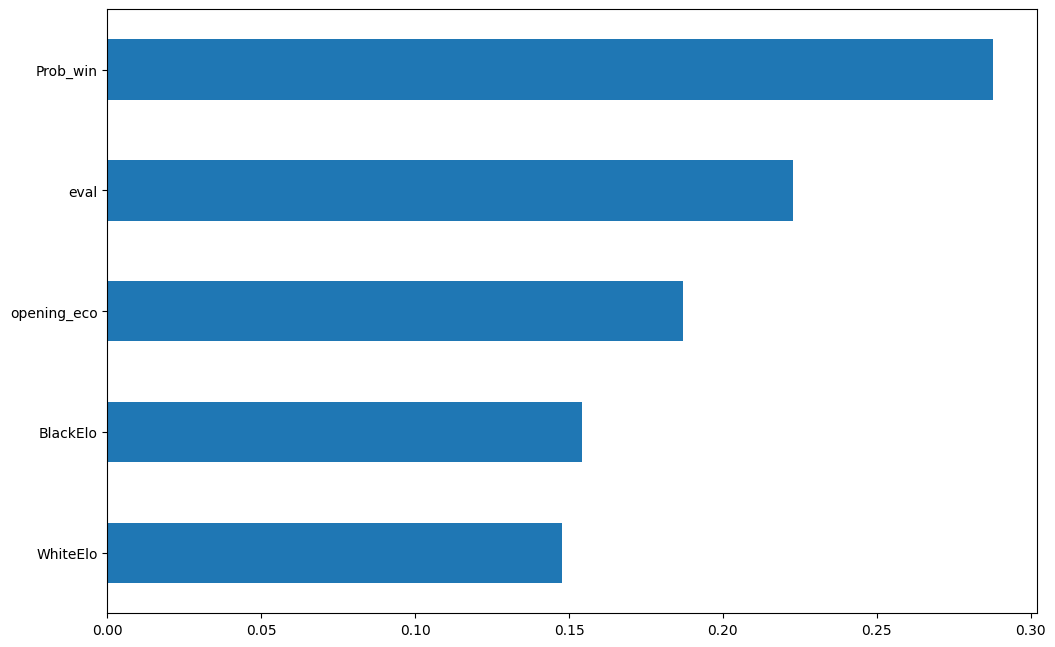

In [171]:
pd.Series(model5.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Model 6 Random forest classifier

In [172]:
model6=RandomForestClassifier(class_weight='balanced')
model6.fit(x_train_scaled, y_train)
y_pred6 = model6.predict(x_test_scaled)

In [173]:
print(accuracy_score(y_test, y_pred6))
print(precision_score(y_test, y_pred6))
print(recall_score(y_test, y_pred6))
prob_6 = model6.predict_proba(x_test_scaled)

0.6156666666666667
0.6291793313069909
0.655893536121673


In [174]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1422
           1       0.63      0.66      0.64      1578

    accuracy                           0.62      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.62      0.62      3000



# Feature Importance

<AxesSubplot:>

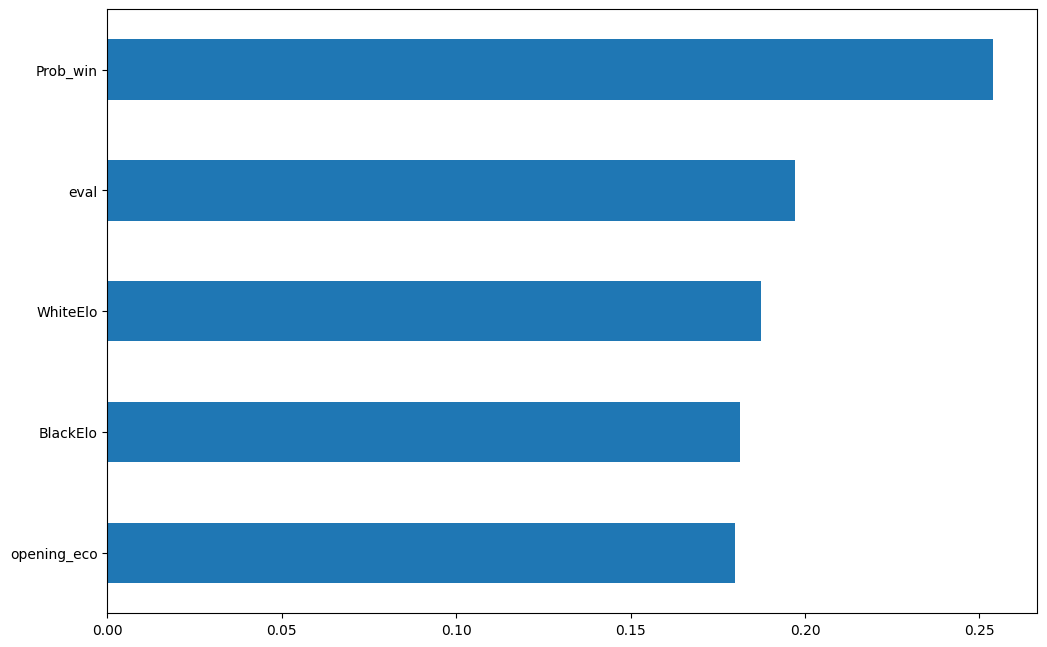

In [175]:
pd.Series(model6.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Model 7 AdaBoost

In [176]:
model7=AdaBoostClassifier()
model7.fit(x_train_scaled, y_train)
y_pred7 = model7.predict(x_test_scaled)

In [177]:
print(accuracy_score(y_test, y_pred7))
print(precision_score(y_test, y_pred7))
print(recall_score(y_test, y_pred7))
prob_7 = model7.predict_proba(x_test_scaled)

0.64
0.6456140350877193
0.6996197718631179


In [178]:
print(classification_report(y_test, y_pred7))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1422
           1       0.65      0.70      0.67      1578

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



# Feature Importance

<AxesSubplot:>

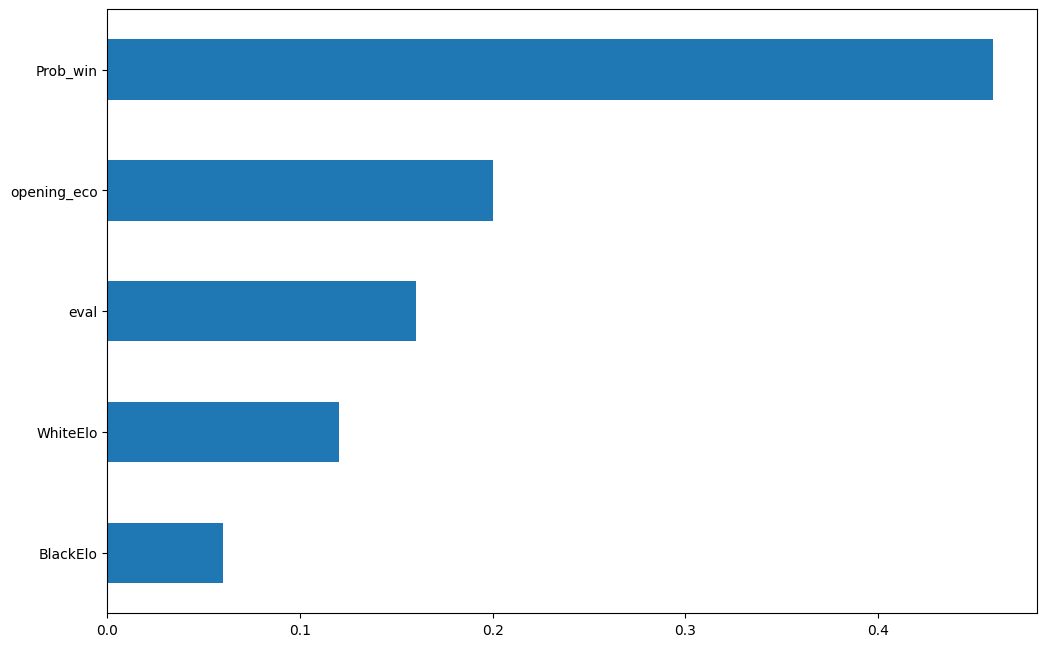

In [179]:
pd.Series(model7.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Modle 8 CatBoost 

In [180]:
model8=CatBoostClassifier()
model8.fit(x_train_scaled, y_train.map(int))
y_pred8 = model8.predict(x_test_scaled)

NameError: name 'CatBoostClassifier' is not defined

In [ ]:
print(accuracy_score(y_test, y_pred8))
print(precision_score(y_test, y_pred8))
print(recall_score(y_test, y_pred8))
prob_8 = model8.predict_proba(x_test_scaled)

0.6666666666666666
0.6675684815691579
0.6590984974958264


In [ ]:
print(classification_report(y_test, y_pred8))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      3017
           1       0.67      0.66      0.66      2995

    accuracy                           0.67      6012
   macro avg       0.67      0.67      0.67      6012
weighted avg       0.67      0.67      0.67      6012



# Feature Importance

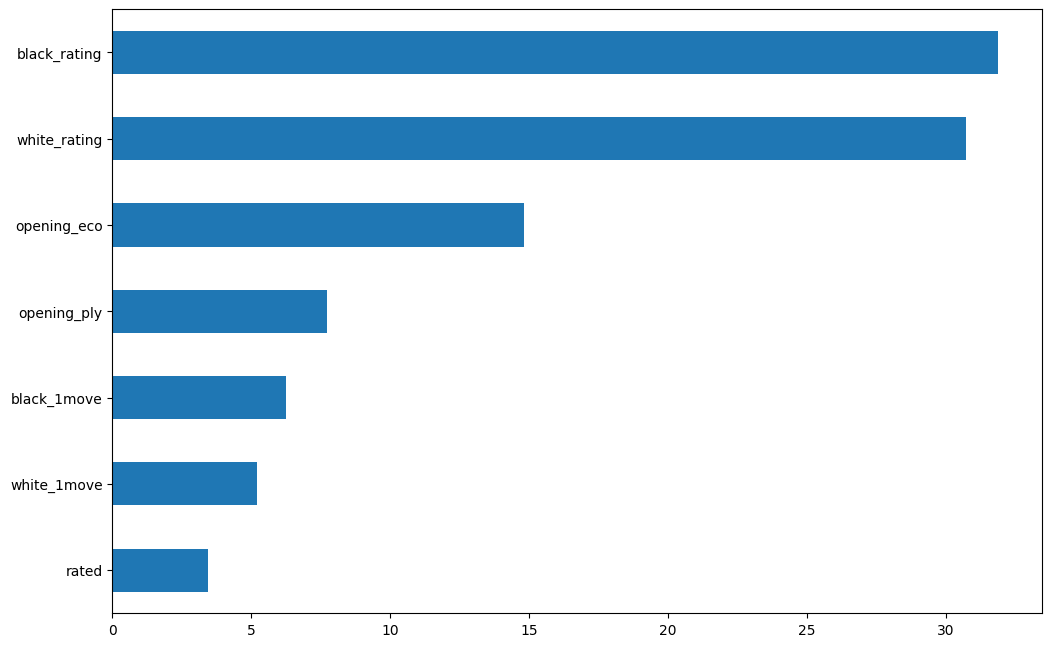

In [ ]:
pd.Series(model8.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Model 9 XGBoost 

In [ ]:
model9=XGBClassifier()
model9.fit(x_train_scaled, y_train)
y_pred9 = model9.predict(x_test_scaled)

b:\Downloads\2023\nqc\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
print(accuracy_score(y_test, y_pred9))
print(precision_score(y_test, y_pred9))
print(recall_score(y_test, y_pred9))
prob_9 = model9.predict_proba(x_test_scaled)

0.6133333333333333
0.6254501800720288
0.6603295310519645


In [ ]:
print(classification_report(y_test, y_pred9))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58      1422
           1       0.63      0.66      0.64      1578

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



# Feature Importance

<AxesSubplot:>

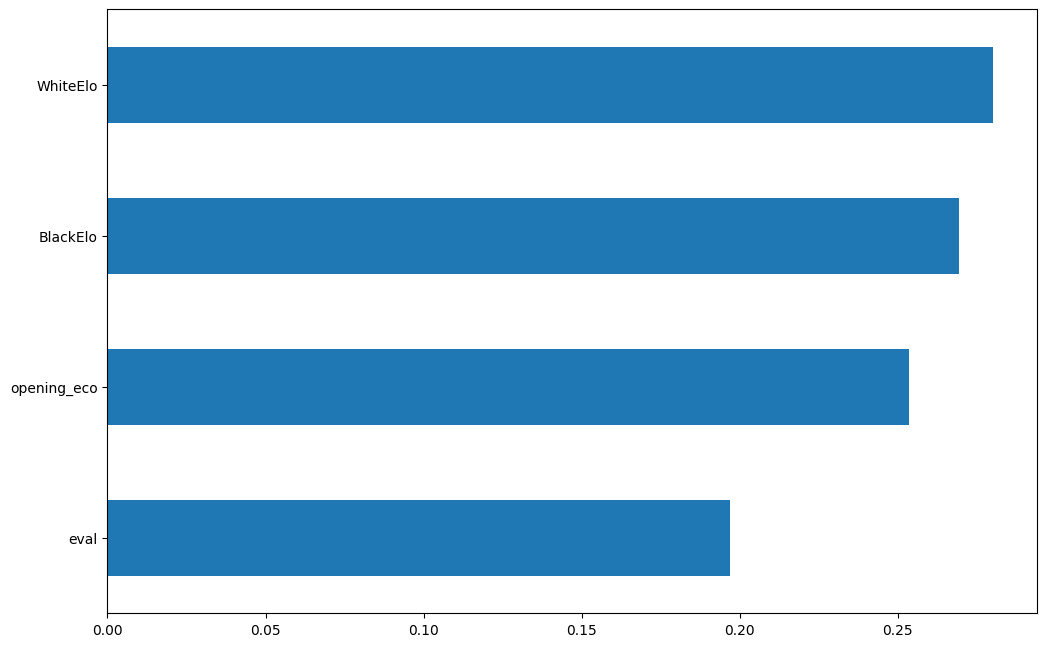

In [ ]:
pd.Series(model9.feature_importances_, index=x_train.columns).sort_values().plot.barh()

### Model 10 LGBM

In [ ]:
model10=LGBMClassifier()
model10.fit(x_train_scaled, y_train)
y_pred10 = model10.predict(x_test_scaled)

In [ ]:
print(accuracy_score(y_test, y_pred10))
print(precision_score(y_test, y_pred10))
print(recall_score(y_test, y_pred10))
prob_10 = model10.predict_proba(x_test_scaled)

0.6256666666666667
0.6369656833232992
0.670468948035488


In [ ]:
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59      1422
           1       0.64      0.67      0.65      1578

    accuracy                           0.63      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.62      0.63      0.62      3000



# Feature Importance

<AxesSubplot:>

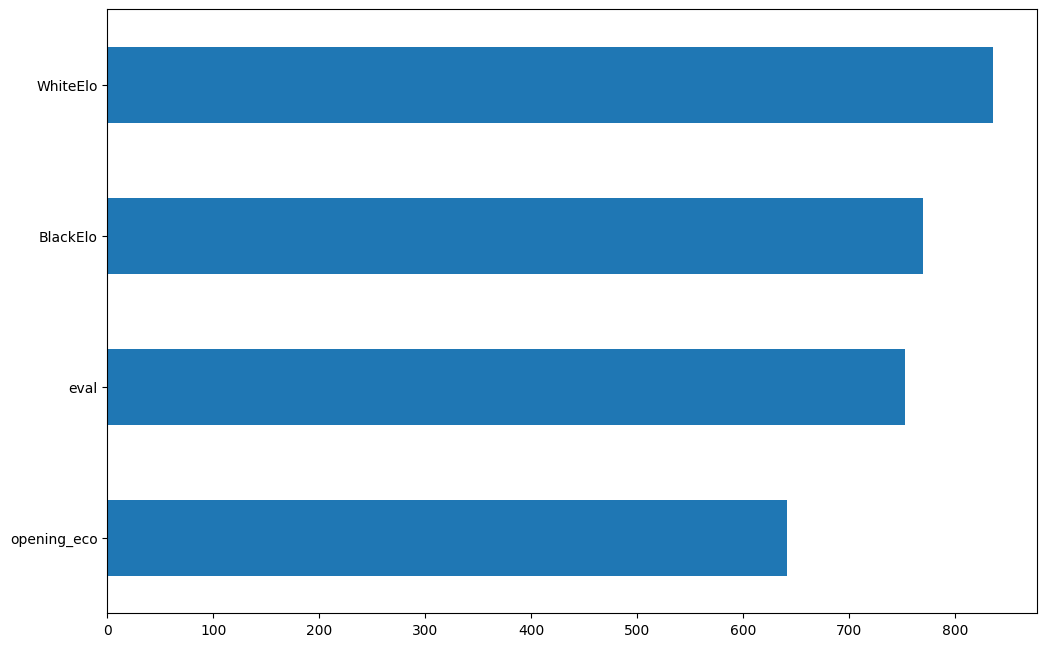

In [ ]:
pd.Series(model10.feature_importances_, index=x_train.columns).sort_values().plot.barh()

# Model Comparison

In [ ]:
a, p, r, f = [], [], [], []
for model in [model1,model2, model3, model4, model5, model6, model7, model8, model9, model10]:
    a.append(accuracy_score(y_test, model.predict(x_test_scaled)))
    p.append(precision_score(y_test, model.predict(x_test_scaled)))
    r.append(recall_score(y_test, model.predict(x_test_scaled)))
    f.append(f1_score(y_test, model.predict(x_test_scaled)))

NameError: name 'model8' is not defined

In [ ]:
model_score = pd.DataFrame([a,p,r,f],
             columns = ['LR',
                        'KNN',
                        'Gausssian',
                        'SVS',
                        'DT',
                        'RF',
                        'AdaB',
                        'CatB',
                        'XGB',
                        'LGBM']).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 

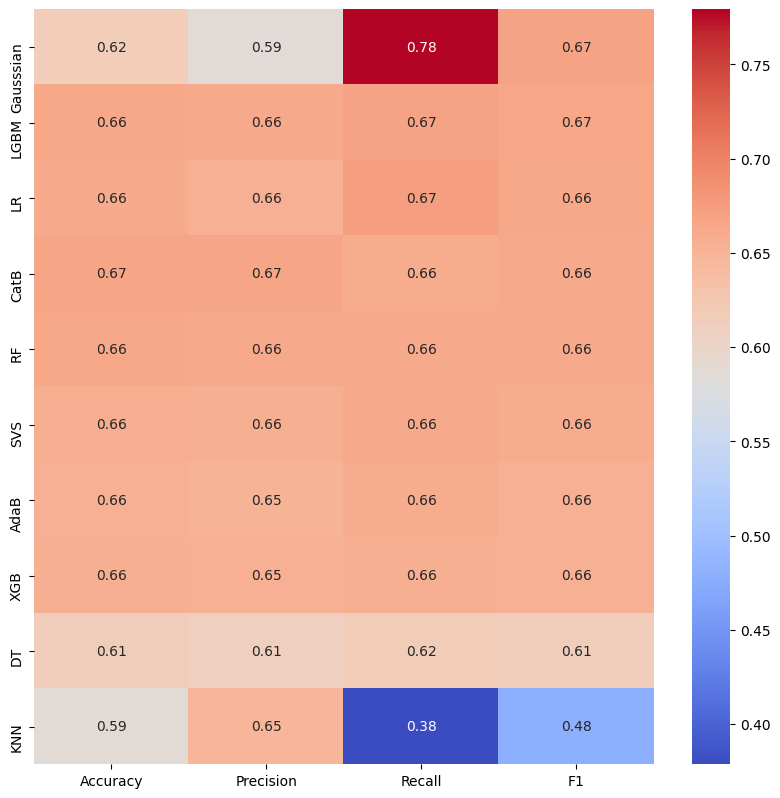

In [ ]:
# Create a heatmap of the summary
plt.figure(figsize= (10,10))
sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
plt.show()

In [ ]:
#x_test_scaled # I dont know who is going to churn, but I want to know

#x_test['prediction']=model10.predict(x_test_scaled)

In [ ]:
#x_test.sample(10)

In [ ]:
#model10.predict_proba(x_test_scaled)[:,1] 

## AUC-ROC curve 

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, prob_1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, prob_2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, prob_3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, prob_4[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, prob_5[:,1], pos_label=1)
fpr6, tpr6, thresh6 = roc_curve(y_test, prob_6[:,1], pos_label=1)
fpr7, tpr7, thresh7 = roc_curve(y_test, prob_7[:,1], pos_label=1)
fpr8, tpr8, thresh8 = roc_curve(y_test, prob_8[:,1], pos_label=1)
fpr9, tpr9, thresh9 = roc_curve(y_test, prob_9[:,1], pos_label=1)
fpr10, tpr10, thresh10 = roc_curve(y_test, prob_10[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, prob_1[:,1])
auc_score2 = roc_auc_score(y_test, prob_2[:,1])
auc_score3 = roc_auc_score(y_test, prob_3[:,1])
auc_score4 = roc_auc_score(y_test, prob_4[:,1])
auc_score5 = roc_auc_score(y_test, prob_5[:,1])
auc_score6 = roc_auc_score(y_test, prob_6[:,1])
auc_score7 = roc_auc_score(y_test, prob_7[:,1])
auc_score8 = roc_auc_score(y_test, prob_8[:,1])
auc_score9 = roc_auc_score(y_test, prob_9[:,1])
auc_score10 = roc_auc_score(y_test, prob_10[:,1])

print(auc_score1, auc_score2,auc_score3, auc_score4, auc_score5, auc_score6, auc_score7, auc_score8, auc_score9, auc_score10)

0.7245614306907491 0.7245614306907491 0.6720511979141017 0.7220967107370975 0.6144523271854594 0.7255057180152757 0.7166697561896057 0.7308646661682852 0.7220688773632775 0.7296366776358564


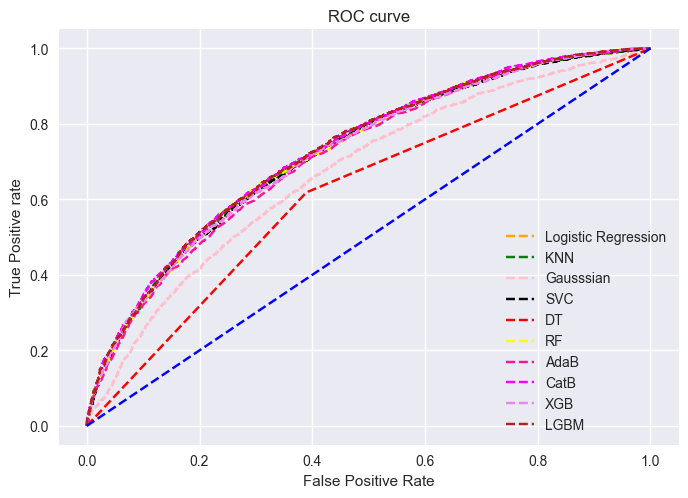

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(fpr3, tpr3, linestyle='--',color='pink', label='Gausssian')
plt.plot(fpr4, tpr4, linestyle='--',color='black', label='SVC')
plt.plot(fpr5, tpr5, linestyle='--',color='red', label='DT')
plt.plot(fpr6, tpr6, linestyle='--',color='yellow', label='RF')
plt.plot(fpr7, tpr7, linestyle='--',color='deeppink', label='AdaB')
plt.plot(fpr8, tpr8, linestyle='--',color='magenta', label='CatB')
plt.plot(fpr9, tpr9, linestyle='--',color='violet', label='XGB')
plt.plot(fpr10, tpr10, linestyle='--',color='firebrick', label='LGBM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
print(max(auc_score1, auc_score2,auc_score3, auc_score4, auc_score5, auc_score6, auc_score7, auc_score8, auc_score9, auc_score10))

0.7308646661682852


CatBoost model AUC score is the maximum score so, I will consider catBoost as a best predictor between all the other 9 models 